In this file, we show how to use the utility functions to run cross validation based on test sequence, and explore if we could improve the performance by seperating the data based on the operation mode.

In utility.py, we define a function `run_cv_one_motor` to run cross validation for a specified motor.

In this analysis, we use the dataset from motor 6, where we have the following operation modes:
- not moving: '20240425_093699', '20240425_094425', '20240426_140055'
- pickup and place: '20240503_163963', '20240325_155003'
- only moving the motor 6: '20240503_164675', '20240503_165189'
We will train a model for each operation mode, and compare the results by mixing all the operation modes together.

From this notebook, you should:
- Understand how to use the utility functions to run cross validation.
- Have some insights about how to improve the performance of the model:
    - Should we select the features?
    - Should we seperate operation modes?
    - Should we consider the history in the prediciton as well?

In [1]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


# Subfunction for data preprocessing.
def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Demo: How to use the utility function for cross validation.

We can use `run_cv_one_motor` to easily run cross validation for one motor. For example, we could run a five-fold cross validation with a logistic regression model using the following code:

Model for motor 6:

 New cv run:

Training performance, accuracy is: 0.8760911736178467
Training performance, precision is: 0.7586206896551724
Training performance, recall: 0.8578391551584078
Training performance, F1: 0.8051849027830728


Prediction performance, accuracy is: 0.22424066269437581
Prediction performance, precision is: 0.014246804944479363
Prediction performance, recall is：0.09700427960057062
Prediction performance, F1 is：0.024844720496894408


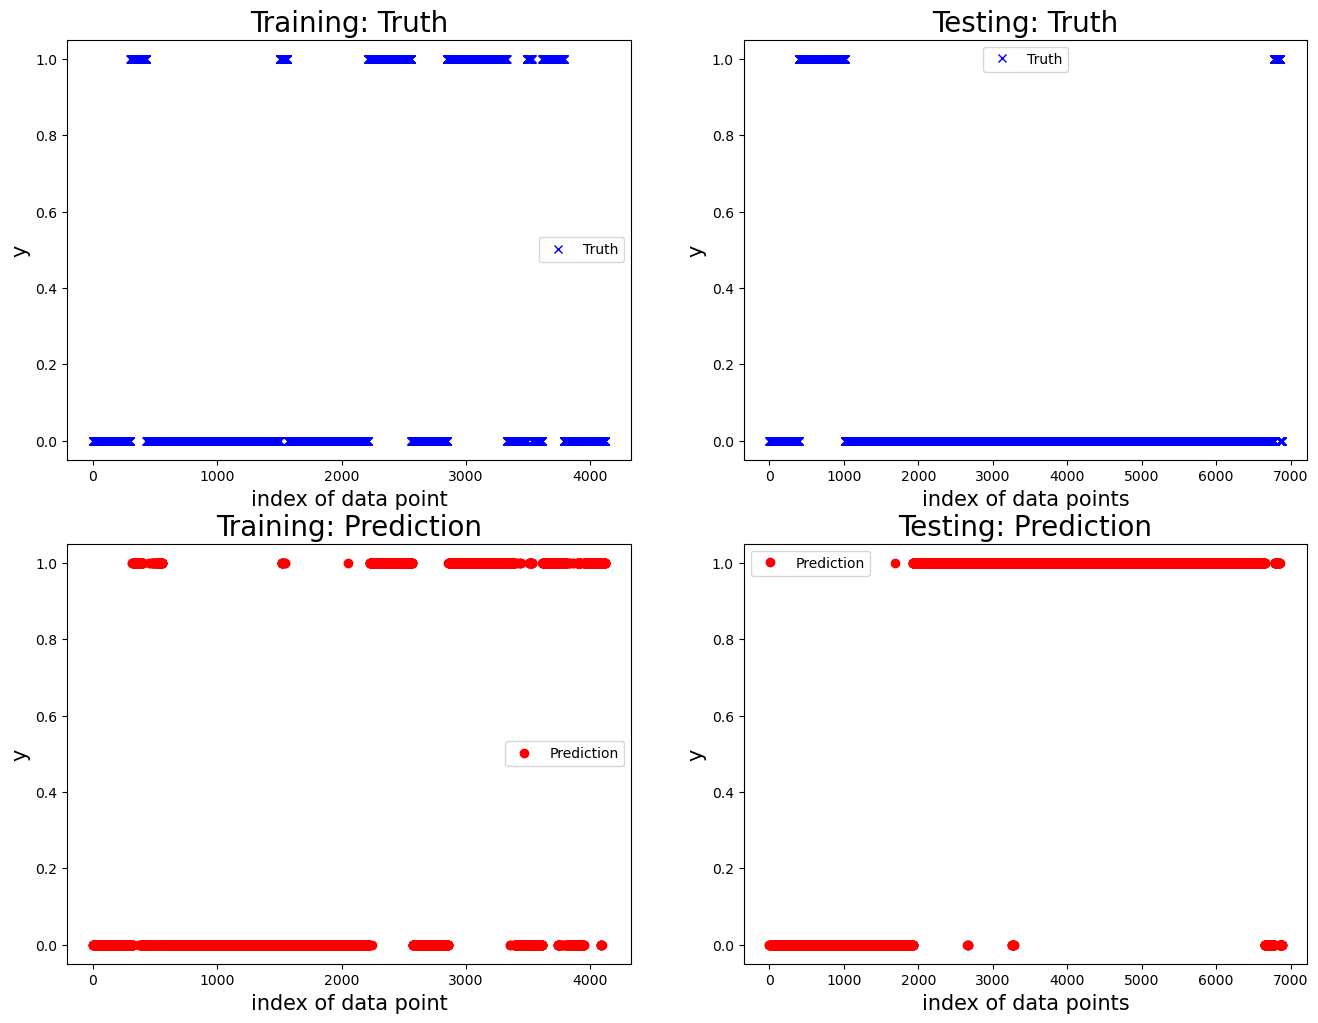


 New cv run:

Training performance, accuracy is: 0.929171540997554
Training performance, precision is: 0.7393048128342246
Training performance, recall: 0.9534482758620689
Training performance, F1: 0.8328313253012047


Prediction performance, accuracy is: 0.7609238451935081
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


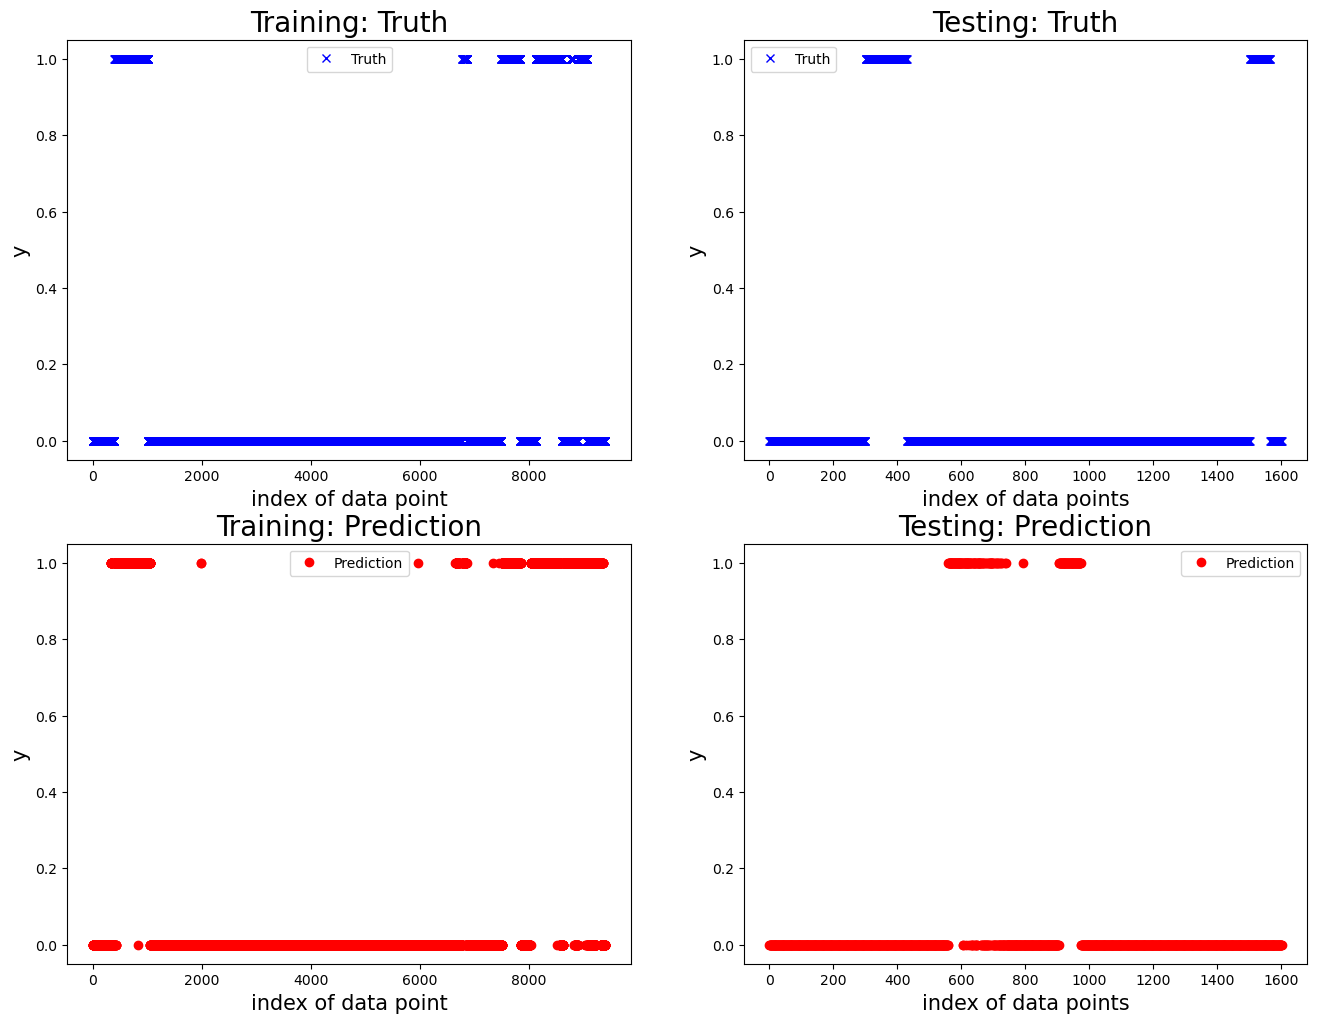


 New cv run:

Training performance, accuracy is: 0.8211423353961652
Training performance, precision is: 0.4723258706467662
Training performance, recall: 0.9583596214511041
Training performance, F1: 0.6327848364923974


Prediction performance, accuracy is: 0.5932055749128919
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


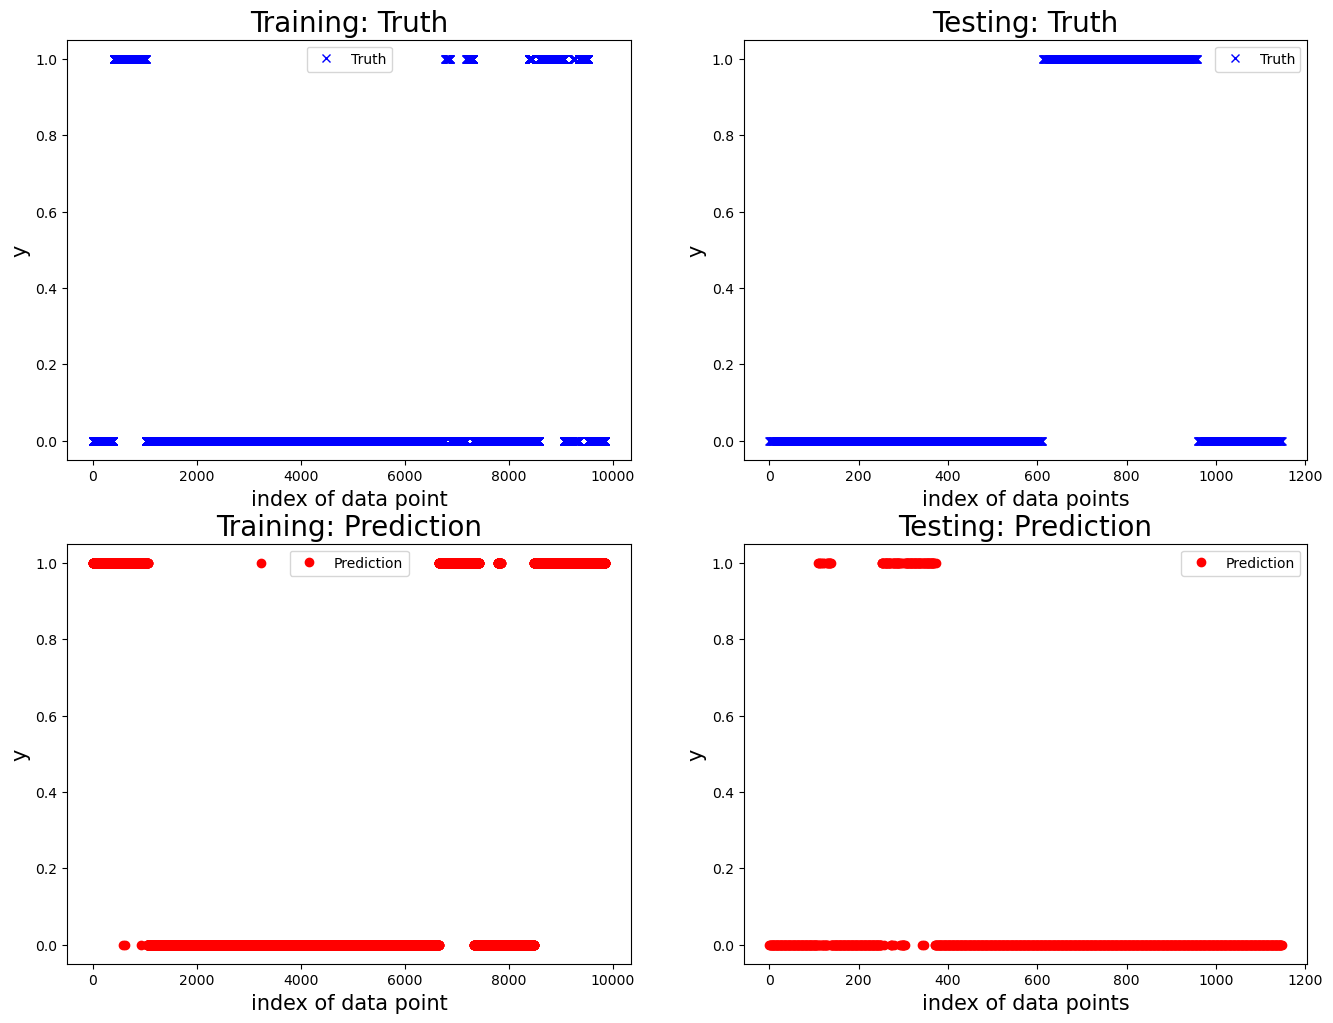


 New cv run:

Training performance, accuracy is: 0.8073412126453349
Training performance, precision is: 0.4159829838954725
Training performance, recall: 0.9428374655647382
Training performance, F1: 0.5772717689226229


Prediction performance, accuracy is: 0.9096989966555183
Prediction performance, precision is: 0.9819004524886877
Prediction performance, recall is：0.9041666666666667
Prediction performance, F1 is：0.9414316702819956


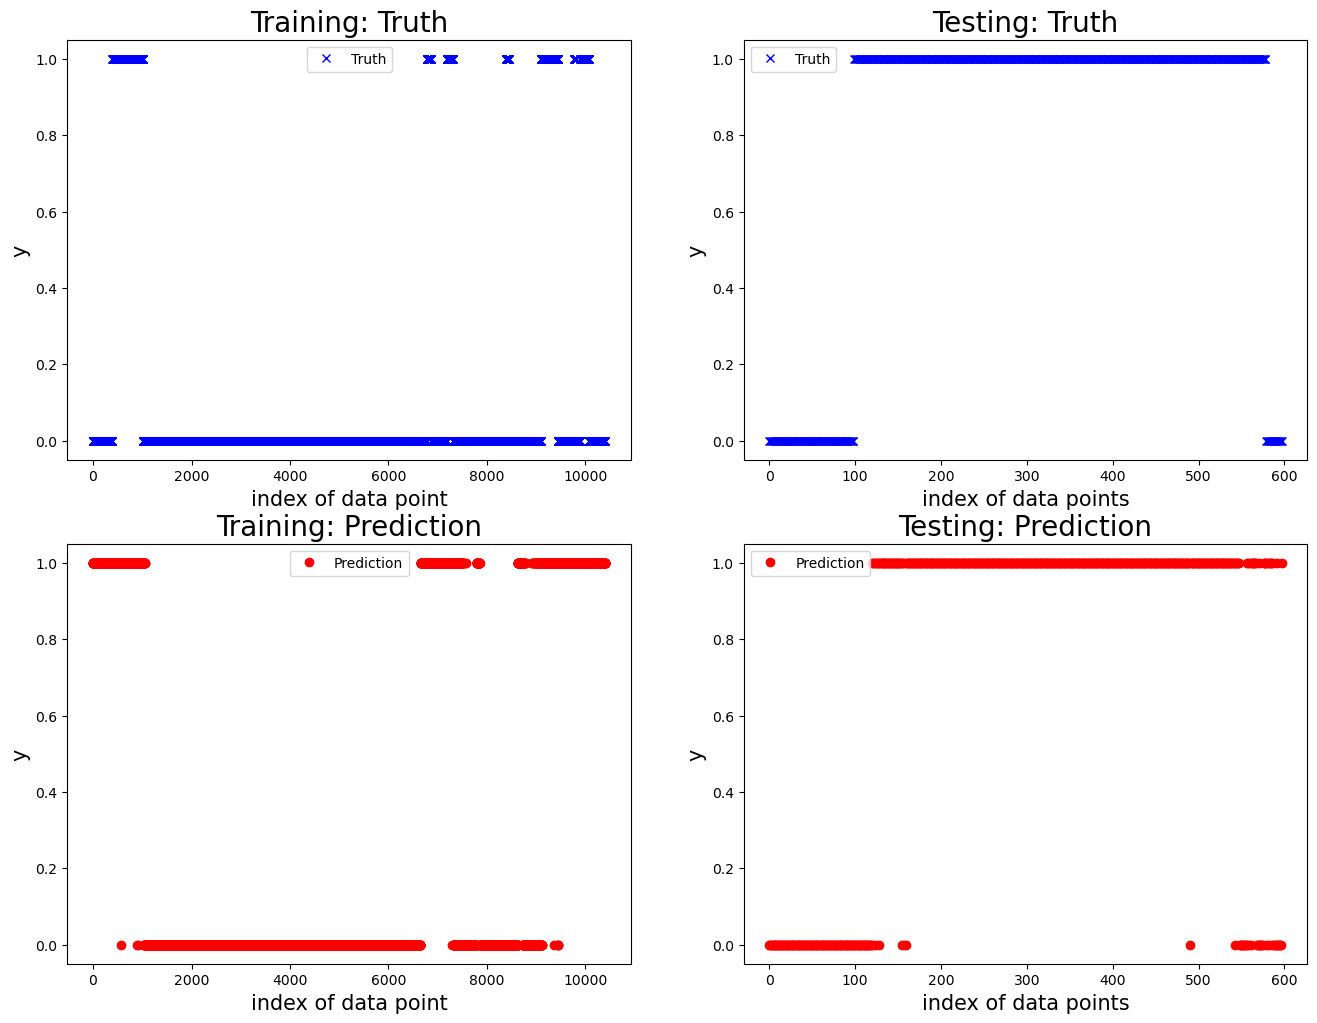


 New cv run:

Training performance, accuracy is: 0.8075080653045263
Training performance, precision is: 0.4613233923578751
Training performance, recall: 0.8633720930232558
Training performance, F1: 0.6013363028953229


Prediction performance, accuracy is: 0.27319587628865977
Prediction performance, precision is: 0.27319587628865977
Prediction performance, recall is：1.0
Prediction performance, F1 is：0.4291497975708502


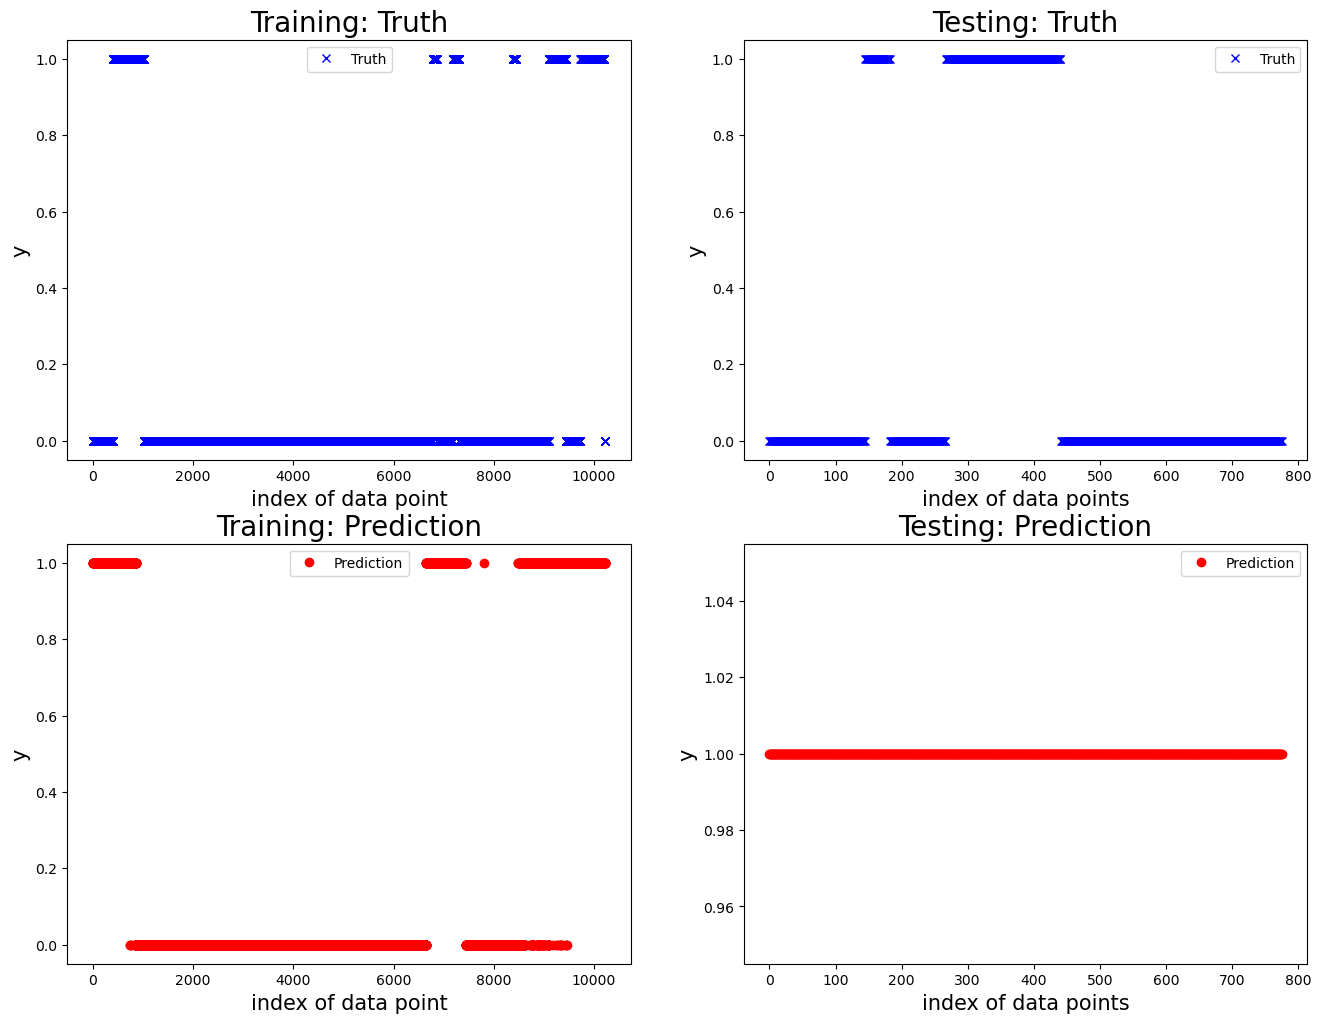

   Accuracy  Precision    Recall  F1 score
0  0.224241   0.014247  0.097004  0.024845
1  0.760924   0.000000  0.000000  0.000000
2  0.593206   0.000000  0.000000  0.000000
3  0.909699   0.981900  0.904167  0.941432
4  0.273196   0.273196  1.000000  0.429150


Mean performance metric and standard error:
Accuracy: 0.5523 +- 0.2994
Precision: 0.2539 +- 0.4233
Recall: 0.4002 +- 0.5065
F1 score: 0.2791 +- 0.4128




In [2]:
from utility import run_cv_one_motor

# Specify the test conditions you would like to include in the test.
df_data_test = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
# We want a five-fold cross validation.
n_cv = 5
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_test, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv)


For each run in the cross validation, the function shows the performance on the training and testing dataset. This can be used for diagnosis and improving the model performance. In the end, the mean performance is printed. 

If you set the parameter `single_run_result=False`, only the final average performance is printed.

# Seperate operation mode

In this section, we seperate the three operation modes, and train a specific model per operation mode. For each operation mode, we further compare:
- Select all the features V.S. select only the positions and the temperature of the current motor.
- window_size=0: only use current measurement V.S. window_size=5: use five previous points together as features.

## Not moving

In [3]:
from utility import run_cv_one_motor


# Define a function to run experiment.
def run_experiment(motor_id, df_data, mdl, window_size, n_fold):
    print(f'window_size={window_size}, all the features.')
    feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_all, n_fold=n_fold, window_size=window_size, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, randomly pick features.')
    feature_list_self = ['time', 'data_motor_6_position', 'data_motor_6_temperature', 
                        'data_motor_5_position', 'data_motor_4_position', 'data_motor_3_position', 'data_motor_2_position', 'data_motor_1_position']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_self, n_fold=n_fold, window_size=window_size, single_run_result=False, mdl_type='clf')

In [5]:
# Not moving
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055'])]
n_cv = 3

# Windowsize = 0.
window_size = 1
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.921739   0.863636  0.926829  0.894118
1  0.731664   0.461538  0.976744  0.626866
2  0.951103   0.588235  0.634921  0.610687


Mean performance metric and standard error:
Accuracy: 0.8682 +- 0.1191
Precision: 0.6378 +- 0.2056
Recall: 0.8462 +- 0.1846
F1 score: 0.7106 +- 0.1592


window_size=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.947826   1.000000  0.853659  0.921053
1  0.542039   0.335065  1.000000  0.501946
2  0.060403   0.060403  1.000000  0.113924


Mean performance metric and standard error:
Accuracy: 0.5168 +- 0.4443
Precision: 0.4652 +- 0.4831
Recall: 0.9512 +- 0.0845
F1 score: 0.5123 +- 0.4037


window_size=5, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.920354   0.872093  0.914634  0.892857
1  0.828829   0.607595  0.744186  0.668990
2  0.060635   0.060635  1.000000  0.114338


Mean perfo

## Move only motor 6.

In [7]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_164675', '20240503_165189'])]
n_cv = 2

# Windowsize = 0.
window_size = 1
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.197324   0.000000     0.0   0.00000
1  0.273196   0.273196     1.0   0.42915


Mean performance metric and standard error:
Accuracy: 0.2353 +- 0.0536
Precision: 0.1366 +- 0.1932
Recall: 0.5000 +- 0.7071
F1 score: 0.2146 +- 0.3035


window_size=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.637124   1.000000  0.547917  0.707941
1  0.278351   0.274611  1.000000  0.430894


Mean performance metric and standard error:
Accuracy: 0.4577 +- 0.2537
Precision: 0.6373 +- 0.5129
Recall: 0.7740 +- 0.3197
F1 score: 0.5694 +- 0.1959


window_size=5, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.191919   0.000000     0.0  0.000000
1  0.274611   0.274611     1.0  0.430894


Mean performance metric and standard error:
Accuracy: 0.2333 +- 0.0585
Precision: 0.1373 +- 0.1942
Recall: 0.5000 +- 0.7071
F1 score: 0.2154 +- 0.3047


## Pick up and place

In [8]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_163963', '20240325_155003'])]
n_cv = 2

# Windowsize = 0.
window_size = 1
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093069   0.093069     1.0  0.170289
1  0.697735   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3954 +- 0.4276
Precision: 0.0465 +- 0.0658
Recall: 0.5000 +- 0.7071
F1 score: 0.0851 +- 0.1204


window_size=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.093069   0.093069  1.000000  0.170289
1  0.263066   0.273799  0.870317  0.416552


Mean performance metric and standard error:
Accuracy: 0.1781 +- 0.1202
Precision: 0.1834 +- 0.1278
Recall: 0.9352 +- 0.0917
F1 score: 0.2934 +- 0.1741


window_size=5, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093125   0.093125     1.0  0.170383
1  0.696678   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3949 +- 0.4268
Precision: 0.0466 +- 0.0658
Recall: 0.5000 +- 0.7071
F1 score: 0.0852 +- 0.1205


# Mix operation mode

In [9]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
n_cv = 7

# Windowsize = 0.
window_size = 1
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.426703   0.000000  0.000000  0.000000
1  0.356522   0.356522  1.000000  0.525641
2  0.769231   0.000000  0.000000  0.000000
3  0.060403   0.060403  1.000000  0.113924
4  0.593206   0.000000  0.000000  0.000000
5  0.909699   0.981900  0.904167  0.941432
6  0.273196   0.273196  1.000000  0.429150


Mean performance metric and standard error:
Accuracy: 0.4841 +- 0.2938
Precision: 0.2389 +- 0.3583
Recall: 0.5577 +- 0.5228
F1 score: 0.2872 +- 0.3611


window_size=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.345662   0.069236  0.484653  0.121163
1  0.926087   1.000000  0.792683  0.884354
2  0.769231   0.000000  0.000000  0.000000
3  0.360499   0.000000  0.000000  0.000000
4  0.525261   0.244845  0.273775  0.258503
5  0.894649   0.900192  0.977083  0.937063
6  0.273196   0.273196  1.000000  0.429150


Mean performance metric and standard error:
A